In [1]:
"""
Learning curves for all labs
@author: Anne Urai, Miles Wells
15 January 2020
"""
import os

import pandas as pd
import numpy as np
from scipy.signal import medfilt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from paper_behavior_functions import (query_subjects, figpath, load_csv, group_colors,
                                      institution_map, seaborn_style, EXAMPLE_MOUSE,
                                      FIGURE_HEIGHT, FIGURE_WIDTH, QUERY)
from ibl_pipeline.analyses import behavior as behavioral_analyses

# INITIALIZE A FEW THINGS
seaborn_style()
figpath = figpath()
pal = group_colors()
institution_map, col_names = institution_map()
col_names = col_names[:-1]

# %% ============================== #
# GET DATA FROM TRAINED ANIMALS
# ================================= #

if QUERY is True:
    use_subjects = query_subjects()
    b = (behavioral_analyses.BehavioralSummaryByDate * use_subjects)
    behav = b.fetch(order_by='institution_short, subject_nickname, training_day',
                    format='frame').reset_index()
    behav['institution_code'] = behav.institution_short.map(institution_map)
else:
    behav = load_csv('Fig2ab.csv')

# exclude sessions with fewer than 100 trials
behav = behav[behav['n_trials_date'] > 100]

# convolve performance over 3 days
for i, nickname in enumerate(behav['subject_nickname'].unique()):
    perf = behav.loc[behav['subject_nickname'] == nickname, 'performance_easy'].values
    perf_conv = np.convolve(perf, np.ones((3,))/3, mode='valid')
    # perf_conv = np.append(perf_conv, [np.nan, np.nan])
    perf_conv = medfilt(perf, kernel_size=3)
    behav.loc[behav['subject_nickname'] == nickname, 'performance_easy'] = perf_conv

# how many mice are there for each lab?
N = behav.groupby(['institution_code'])['subject_nickname'].nunique().to_dict()
behav['n_mice'] = behav.institution_code.map(N)
behav['institution_name'] = behav.institution_code + '\n ' + behav.n_mice.apply(str) + ' mice'

# make sure each mouse starts at 0
for index, group in behav.groupby(['lab_name', 'subject_nickname']):
    behav.loc[group.index, 'training_day'] = group['training_day'] - group['training_day'].min()

# create another column only after the mouse is trained
behav2 = pd.DataFrame([])
for index, group in behav.groupby(['institution_code', 'subject_nickname']):
    group['performance_easy_trained'] = group.performance_easy
    group.loc[pd.to_datetime(group['session_date']) < pd.to_datetime(group['date_trained']),
              'performance_easy_trained'] = np.nan
    # add this
    behav2 = behav2.append(group)

behav = behav2
behav['performance_easy'] = behav.performance_easy * 100
behav['performance_easy_trained'] = behav.performance_easy_trained * 100

# Create column for cumulative trials per mouse
behav.n_trials_date = behav.n_trials_date.astype(int)
behav['cum_trials'] = (
    (behav
        .groupby(by=['subject_uuid'])
        .cumsum()
        .n_trials_date)
)


Connecting dbadmin@datajoint-rds.cyuksi65nrdq.us-east-1.rds.amazonaws.com:3306
Connected to https://alyx.internationalbrainlab.org as vathes
Connected to https://alyx.internationalbrainlab.org as vathes


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


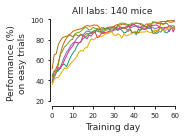

In [2]:
# Plot all labs
fig, ax1 = plt.subplots(1, 1, figsize=(FIGURE_WIDTH/3, FIGURE_HEIGHT))
sns.lineplot(x='training_day', y='performance_easy', hue='institution_code', palette=pal,
             ax=ax1, legend=False, data=behav, ci=None)
ax1.set_title('All labs: %d mice'%behav['subject_nickname'].nunique())
ax1.set(xlabel='Training day',
        ylabel='Performance (%)\non easy trials', xlim=[-1, 60], ylim=[15, 100])
ax1.set(xticks=[0, 10, 20, 30, 40, 50, 60])

sns.despine(trim=True)
plt.tight_layout()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


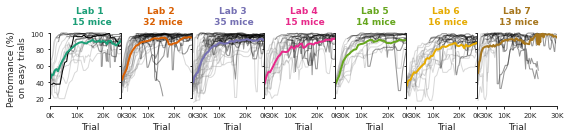

In [3]:

###############
# plot one curve for each animal, one panel per lab
fig = sns.FacetGrid(behav,
                    col="institution_code", col_wrap=7, col_order=col_names,
                    sharex=True, sharey=True, hue="subject_uuid", xlim=[-1, 3e4],
                    height=FIGURE_HEIGHT, aspect=(FIGURE_WIDTH / 7) / FIGURE_HEIGHT)
fig.map(sns.lineplot, "cum_trials",
        "performance_easy", color='grey', alpha=0.3)
fig.map(sns.lineplot, "cum_trials",
        "performance_easy_trained", color='black', alpha=0.3)
fig.set_titles("{col_name}")
format_fcn = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x / 1e3) + 'K')

# overlay the example mouse
sns.lineplot(ax=fig.axes[0], x='cum_trials', y='performance_easy', color='black',
             data=behav[behav['subject_nickname'].str.contains(EXAMPLE_MOUSE)], legend=False)

for axidx, ax in enumerate(fig.axes.flat):
    # add the lab mean to each panel
    d = (behav.loc[behav.institution_name == behav.institution_name.unique()[axidx], :])\
        .groupby('training_day').mean()  # Binning by day
    sns.lineplot(data=d, x='cum_trials', y='performance_easy',
                 color=pal[axidx], ci=None, ax=ax, legend=False, linewidth=2)
    ax.set_title(behav.institution_name.unique()[
                 axidx], color=pal[axidx], fontweight='bold')
    fig.set(xticks=[0, 10000, 20000, 30000])
    ax.xaxis.set_major_formatter(format_fcn)

fig.set_axis_labels('Trial', 'Performance (%)\n on easy trials')
fig.despine(trim=True)
plt.tight_layout(w_pad=-2.2)

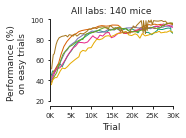

In [4]:
# Plot all labs
d = behav.groupby(['institution_code', 'training_day']).mean()  # Binned by day

fig, ax1 = plt.subplots(1, 1, figsize=(FIGURE_WIDTH/3, FIGURE_HEIGHT))
sns.lineplot(x='cum_trials', y='performance_easy', hue='institution_code', palette=pal,
             ax=ax1, legend=False, data=d, ci=None)
ax1.set_title('All labs: %d mice' % behav['subject_nickname'].nunique())
ax1.set(xlabel='Trial',
        ylabel='Performance (%)\non easy trials', xlim=[-1, 30000], ylim=[15, 100])
ax1.xaxis.set_major_formatter(format_fcn)

sns.despine(trim=True)
plt.tight_layout()

In [5]:
# ================================= #
# print some stats
# ================================= #
behav_summary_std = behav.groupby(['training_day'])[
    'performance_easy'].std().reset_index()
behav_summary = behav.groupby(['training_day'])[
    'performance_easy'].mean().reset_index()
print('number of days to reach 80% accuracy on easy trials: ')
print(behav_summary.loc[behav_summary.performance_easy >
                        80, 'training_day'].min())


# ================================= #
# print some stats
# ================================= #
behav_summary_std = behav.groupby(['training_day'])[
    ['performance_easy', 'cum_trials']].std().reset_index()
behav_summary = behav.groupby(['training_day'])[
    ['performance_easy', 'cum_trials']].mean().reset_index()
print('number of trials to reach 80% accuracy on easy trials: ')
print(behav_summary.loc[behav_summary.performance_easy >
                        80, 'cum_trials'].round().min())

number of days to reach 80% accuracy on easy trials: 
12
number of trials to reach 80% accuracy on easy trials: 
7375.0
